In [1]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow

data, data_labels = [],[]
file_names = []
H, W = 360, 540
for file in os.listdir('./PCIA_Resolved_imgs'):
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    image = Image.open('./PCIA_Resolved_imgs/'+file)
    #print(image.shape)
    #print(file)
    if(image.size[1]) < H:
      continue
    img_new = image.resize((W,H))
    data.append(np.array(img_new)[:,:,:3])
    data_labels.append(0)
    file_names.append(file)

print(len(data))


100


In [ ]:
print(image.format, image.size, image.mode)

JPEG (5472, 3648) RGB


In [6]:
print(len(data))

216


In [4]:
active_count = 0
for file in sorted(os.listdir('./PCIA_Active_imgs')):
  if active_count > 115:
    break
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    #print(file)
    image = Image.open('./PCIA_Active_imgs/'+file)
    if image.size[1] < H:
      continue
    img_new = image.resize((W,H))
    data.append(np.array(img_new)[:,:,:3])
    data_labels.append(1)
    file_names.append(file)
    active_count += 1


print(active_count)

116


In [ ]:
data[0].shape

(360, 540, 3)

In [7]:
from sklearn.utils import shuffle
np.random.seed(0)
data, data_labels = np.array(data), np.array(data_labels)
N = len(data)
# Train - 80% (15% of which is used as validation data)
# Test - 20%
s_data, s_data_labels = shuffle(data, data_labels, random_state = 9)
x_train, y_train = s_data[:(N*69)//100, :,:,:], s_data_labels[:(N*69)//100]
x_val, y_val = s_data[(N*69)//100:(N*80)//100 , :,:,:], s_data_labels[(N*69)//100:(N*80)//100]
x_test, y_test = s_data[(N*80)//100: , :,:,:], s_data_labels[(N*80)//100:]
#x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(149, 360, 540, 3)
(44, 360, 540, 3)
(23, 360, 540, 3)


In [8]:
np.sum(y_train)

76

In [9]:
!pip install image-classifiers

     |████████████████████████████████| 51kB 2.7MB/s 


In [52]:
###Feature-extraction with VGG16
#load the pretrained EfficientNetB2 model from keras with pretrained weights on imagenet
import tensorflow as tf
# from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, EfficientNetB0, EfficientNetB4
from classification_models.keras import Classifiers

#Seresnet34, preprocess_input = Classifiers.get('seresnet34')
Resnet18, preprocess_input = Classifiers.get('resnet18')

tf.random.set_seed(9)

inputs = layers.Input(shape=(360,540, 3))
#model = Resnet18(input_tensor= inputs, weights='imagenet', include_top=False)
#model = Seresnet34(input_tensor= inputs, weights='imagenet', include_top=False)
#model = ResNet50V2(input_tensor= inputs, include_top = False, weights = 'imagenet')
#model = MobileNetV2(input_tensor= inputs, include_top = False, weights = 'imagenet')
model = EfficientNetB0(input_tensor= inputs, include_top = False, weights = 'imagenet')

model.trainable = False

#x = layers.Conv2D(256, 1, activation='relu')(model.output)
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)


#----rip---
#x = layers.BatchNormalization()(x)
x = layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
#x = layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.4, seed = 0)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(2, activation="softmax")(x)
model = Model(inputs, outputs)
#print(len(new_model.layers))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 360, 540, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 360, 540, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 360, 540, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 361, 541, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [46]:
len(model.layers)

243

In [11]:
import keras
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
mc = ModelCheckpoint('weights_best_model_effnet.hdf5', monitor='val_accuracy', save_best_only=True)
#one_hot_label = to_categorical(y_train)
opt = keras.optimizers.Adam(learning_rate=0.001,amsgrad =True)
model.compile(loss = 'categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
aug = ImageDataGenerator( horizontal_flip=True, zoom_range=0.1, vertical_flip = True, width_shift_range=0.075)
#aug = ImageDataGenerator(rotation_range=9, zoom_range=0.1, width_shift_range=0.1,height_shift_range=0.12,
#                         horizontal_flip=True, vertical_flip = True,fill_mode="nearest")
# train the network
# H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
# 	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
# 	epochs=EPOCHS)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True

In [48]:
hist = model.fit(aug.flow(x_train, to_categorical(y_train)), validation_data= (x_val, to_categorical(y_val)),
                 epochs=40, callbacks = [mc], batch_size = 64, verbose=2)

Epoch 1/40
5/5 - 15s - loss: 2.2946 - accuracy: 0.6577 - val_loss: 1.6179 - val_accuracy: 0.7391
Epoch 2/40
5/5 - 6s - loss: 1.7725 - accuracy: 0.7584 - val_loss: 1.7752 - val_accuracy: 0.4783
Epoch 3/40
5/5 - 6s - loss: 1.6416 - accuracy: 0.7785 - val_loss: 1.6397 - val_accuracy: 0.7826
Epoch 4/40
5/5 - 6s - loss: 1.4116 - accuracy: 0.8456 - val_loss: 1.5116 - val_accuracy: 0.7826
Epoch 5/40
5/5 - 6s - loss: 1.3733 - accuracy: 0.8859 - val_loss: 1.3851 - val_accuracy: 0.8261
Epoch 6/40
5/5 - 6s - loss: 1.4003 - accuracy: 0.8456 - val_loss: 1.3554 - val_accuracy: 0.8261
Epoch 7/40
5/5 - 6s - loss: 1.3078 - accuracy: 0.8859 - val_loss: 1.2771 - val_accuracy: 0.9130
Epoch 8/40
5/5 - 6s - loss: 1.2671 - accuracy: 0.8725 - val_loss: 1.2544 - val_accuracy: 0.9130
Epoch 9/40
5/5 - 6s - loss: 1.2406 - accuracy: 0.8792 - val_loss: 1.2473 - val_accuracy: 0.9130
Epoch 10/40
5/5 - 6s - loss: 1.1359 - accuracy: 0.9463 - val_loss: 1.1964 - val_accuracy: 0.9130
Epoch 11/40
5/5 - 6s - loss: 1.2144 - 

In [53]:
model.load_weights('weights_best_modelhead.hdf5')##EFFECIENTNET -- 93%

In [52]:
model.load_weights('weights_best_model_effnet.hdf5')

In [26]:
model.load_weights('weights_best_model_resnet18body.hdf5')##RESNET

In [ ]:
model.layers[-37].name

'block7a_expand_conv'

In [ ]:
#Unfreezing outer layers and for further fine tuning.
for layer in model.layers[-37:]:
        if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
hist_1 = model.fit(aug.flow(x_train, to_categorical(y_train)), validation_data= (x_val, to_categorical(y_val)),
                   callbacks = [mc], epochs= 40, verbose=2)

In [42]:
model.save("95_resnet18.h5")

In [23]:
model = tf.keras.models.load_model('95_resnet18.h5')

In [51]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 360, 540, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 360, 540, 3)  9           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 366, 546, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 180, 270, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

In [54]:
train_preds = model.predict(x_train)
y_pred_train = np.argmax(train_preds, axis=1)
print("Training accuracy = :")
print(np.mean(y_pred_train == y_train))

Training accuracy = :
0.9664429530201343


In [55]:
##testing on original model:
preds = model.predict(x_test)
val_preds = model.predict(x_val)


In [ ]:
val_preds

In [56]:
preds

array([[8.9826477e-01, 1.0173524e-01],
       [9.9814236e-01, 1.8576513e-03],
       [9.7788382e-01, 2.2116201e-02],
       [1.3769692e-03, 9.9862301e-01],
       [6.8898714e-04, 9.9931097e-01],
       [9.4909948e-01, 5.0900567e-02],
       [5.0722301e-04, 9.9949276e-01],
       [5.7466137e-01, 4.2533866e-01],
       [3.3747181e-01, 6.6252822e-01],
       [1.6182624e-01, 8.3817375e-01],
       [9.1739845e-01, 8.2601577e-02],
       [3.6431842e-02, 9.6356821e-01],
       [5.2866381e-01, 4.7133619e-01],
       [7.6684982e-01, 2.3315015e-01],
       [9.6884179e-01, 3.1158272e-02],
       [2.4978916e-01, 7.5021088e-01],
       [1.8347184e-03, 9.9816531e-01],
       [1.0187955e-03, 9.9898118e-01],
       [3.1316821e-02, 9.6868312e-01],
       [6.8677673e-03, 9.9313229e-01],
       [9.8696649e-01, 1.3033487e-02],
       [9.2934281e-01, 7.0657142e-02],
       [9.6386194e-02, 9.0361375e-01],
       [8.2799608e-01, 1.7200391e-01],
       [9.1531777e-01, 8.4682234e-02],
       [7.0130511e-04, 9.

In [26]:
res_probs = preds[:,1]

In [17]:
eff_probs = preds[:,1]

In [ ]:
to_categorical(y_test)

In [57]:
#y_pred = np.array([1 if num > 0.5 else 0 for num in preds])
# print(predictions)
scores = np.max(preds, axis = 1)
y_pred = np.argmax(preds, axis=1)
y_pred_val = np.argmax(val_preds, axis=1)
print(y_pred)
print(y_test)
print(y_pred.shape)
print(np.mean(y_pred == y_test))
print("Val accuracy = :")
print(np.mean(y_pred_val == y_val))

[0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0
 1 1 0 1 1 0 1]
[0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0
 1 1 0 1 1 0 1]
(44,)
0.9318181818181818
Val accuracy = :
1.0


In [67]:
scores[mis_class]

array([0.99940145, 0.93800586], dtype=float32)

In [66]:
mis_class = (np.where(y_pred != y_test))[0]
mis_class

array([ 8, 12])

In [68]:
y_pred[mis_class]

array([0, 0])

8


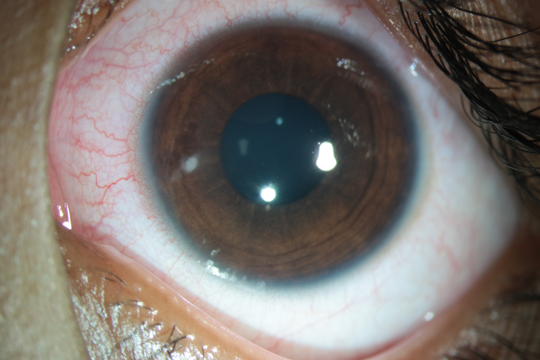

12


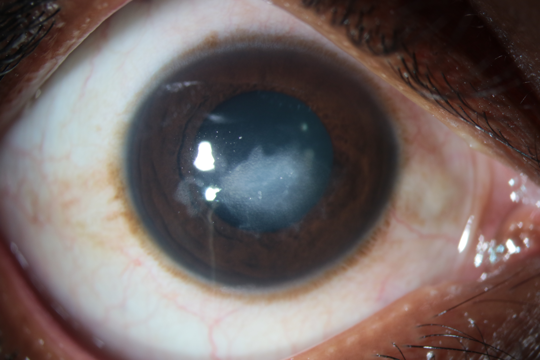

In [40]:
##67A -- 30
for i in mis_class:
  print(i)
  img_ = cv2.cvtColor(x_test[i],cv2.COLOR_RGB2BGR)
  cv2_imshow(img_)

In [ ]:
val_loss

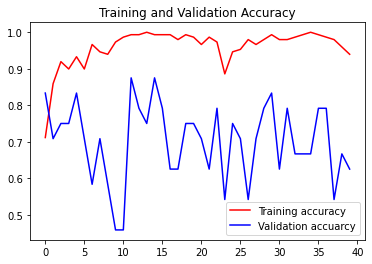

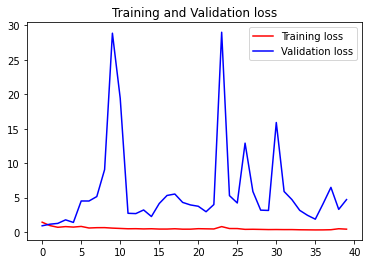

In [ ]:
##PLOTS
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training accuracy")

plt.plot(epochs, val_acc, 'b', label = "Validation accuarcy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

##GRADCAM


In [38]:
%cd /content/

/content


In [29]:
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0)/ tf.math.reduce_max(heatmap)
    # hm = heatmap.numpy()
    # hm -= np.min(hm)
    # hm /= np.max(hm)
    return heatmap

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    #print(heatmap.max())

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)
    
    #print(jet.shape)

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

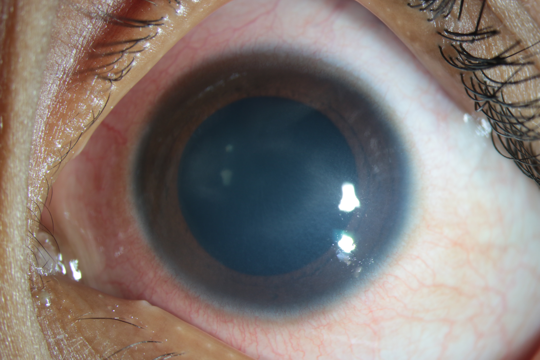

In [24]:
##Testing image.
img_ = cv2.cvtColor(x_test[-5],cv2.COLOR_RGB2BGR)
cv2_imshow(img_)

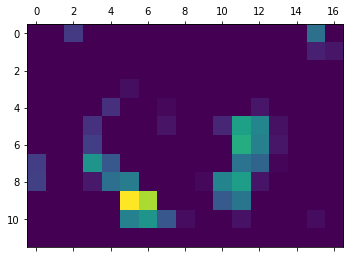

In [40]:
img_arr = np.expand_dims(x_test[-5], axis = 0)
hm = make_gradcam_heatmap(img_arr, model, 'top_activation', pred_index=1)
plt.matshow(hm)
plt.show()


In [41]:
save_and_display_gradcam(img = x_test[-5], heatmap = hm)

##Confusion matrix and ROC-AUC Curve



In [40]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


In [62]:
cm = confusion_matrix(y_test, y_pred)
print("tpr = ", cm[1][1]/(cm[1][0]+cm[1][1]))
print("fpr = ", cm[0][1]/(cm[0][0]+cm[0][1]))

tpr =  0.8888888888888888
fpr =  0.0


In [63]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


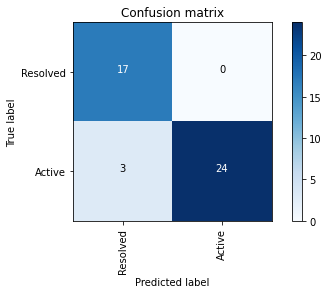

In [64]:
plot_confusion_matrix(cm, ['Resolved', 'Active'])

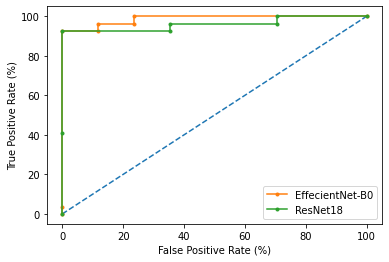

Effnet auc =  0.9869281045751633
resnet auc =  0.9607843137254902


In [29]:
##ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]
res_auc = roc_auc_score(y_test, res_probs)
eff_auc = roc_auc_score(y_test, eff_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
res_fpr, res_tpr, _ = roc_curve(y_test, res_probs)
eff_fpr, eff_tpr, _ = roc_curve(y_test, eff_probs)
# plot the roc curve for the model
pyplot.plot(100*ns_fpr, 100*ns_tpr, linestyle='--')
pyplot.plot(100*eff_fpr, 100*eff_tpr, marker='.', label='EffecientNet-B0')
pyplot.plot(100*res_fpr, 100*res_tpr, marker='.', label='ResNet18')
pyplot.xlabel('False Positive Rate (%)')
pyplot.ylabel('True Positive Rate (%)')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print("Effnet auc = ", eff_auc)
print("resnet auc = ", res_auc)



###XGBoost Classifier

In [58]:
feat_model = keras.Model(model.input, model.get_layer("avg_pool").output)
feature_extractor = feat_model.predict(x_train)
train_features = feature_extractor.reshape(feature_extractor.shape[0], -1)

feature_vec = feat_model.predict(x_test)
test_features = feature_vec.reshape(feature_vec.shape[0], -1)

In [59]:
print(train_features.shape)
print(y_train.shape)

(149, 1280)
(149,)


In [60]:

import xgboost as xgb
model_xg = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

eval_set = [(train_features, y_train), (test_features, y_test)]
model_xg.fit(train_features, y_train, early_stopping_rounds = 10, eval_metric=["logloss"],
          eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

[0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0
 1 1 0 1 1 0 0]
[0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0
 1 1 0 1 1 0 1]
Accuracy: 0.8636363636363636
0.9172113289760349


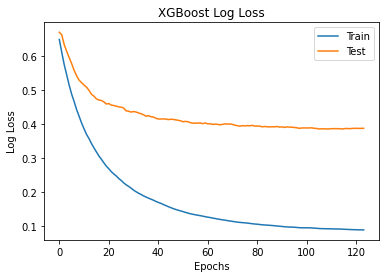

In [61]:
import matplotlib.pyplot as plt


# make predictions for test data
preds = model_xg.predict(test_features)
probs = model_xg.predict_proba(test_features)
print(preds)
print(y_test)
acc = np.mean(preds == y_test)
print(f"Accuracy: {acc}")
xgb_auc = roc_auc_score(y_test, probs[:,1])
print(xgb_auc)
results = model_xg.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()

In [65]:
cm = confusion_matrix(y_test, preds)
print("tpr = ", cm[1][1]/(cm[1][0]+cm[1][1]))
print("fpr = ", cm[0][1]/(cm[0][0]+cm[0][1]))

tpr =  0.7777777777777778
fpr =  0.0


Confusion matrix, without normalization


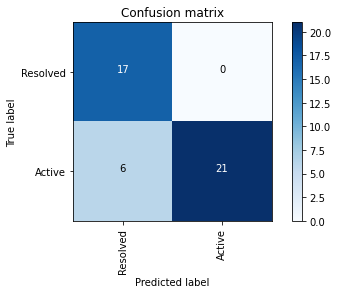

In [66]:
#cm
plot_confusion_matrix(cm, ['Resolved', 'Active'])